In [1]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Importation des valeurs

In [2]:
alpha = 0.15
b = 1
sigma = 0.2
T = 1
r = 0.05
K = 4
k = 20
dt = 1/20
S_0 = 5 #le fixer à 1 si on veut obtenir les cheveux 
nb_samples = 100

# Test du CIR 

In [3]:
import CIR

In [4]:
S = CIR.CIR(alpha, b, sigma, T, k, S_0)
S1 = CIR.CIR_new(alpha, b, sigma, T/k, T, S_0)

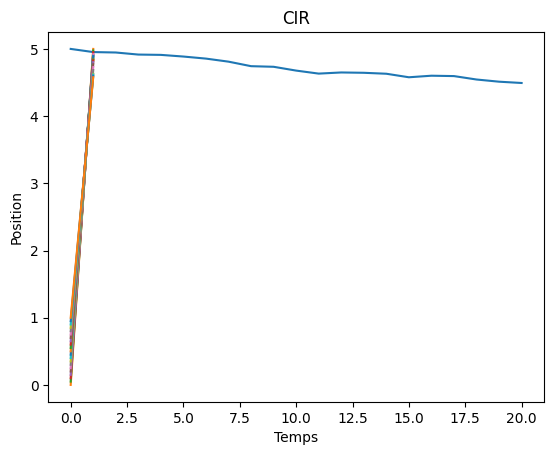

In [5]:
plt.plot(S)
plt.plot(S1)
plt.xlabel('Temps')
plt.ylabel('Position')
plt.title('CIR')
plt.show()

In [6]:
nb_samples = 100

In [7]:
M = CIR.multiCIR(alpha, b, sigma, T, k, S_0, nb_samples)

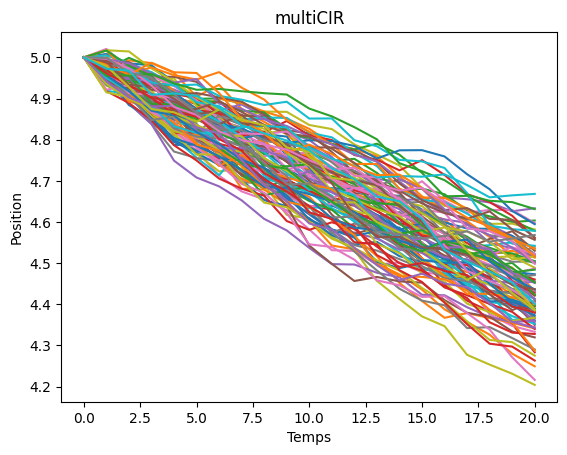

In [8]:
for i in range(nb_samples):
    plt.plot(M[i])
plt.xlabel('Temps')
plt.ylabel('Position')
plt.title('multiCIR')
plt.show()

# Monte Carlo Ordinaire

In [9]:
import ordinaryMC

In [10]:
ordinaryMC.pv_calc(M[3],r, T)

array([4.75614712, 4.75281353, 4.69823013, 4.64726654, 4.6648701 ,
       4.64811821, 4.65373794, 4.61248167, 4.59834036, 4.54786867,
       4.52339538, 4.47224715, 4.4427962 , 4.4013178 , 4.37067965,
       4.35178024, 4.32699979, 4.28129517, 4.274636  , 4.25861807,
       4.24286637])

In [11]:
OMC = ordinaryMC.ordinary_mc_sim(nb_samples, k, S_0, T, r, sigma, K, alpha, b)

In [12]:
np.mean(OMC)

0.6662617235910904

In [13]:
ordinaryMC.sim_iterator(1000, k, S_0, T, r, sigma, K, alpha, b)

(array([0.68578557, 0.67022116, 0.68322346, 0.6754803 , 0.67921184,
        0.67934609, 0.67656233, 0.68295285, 0.68089584, 0.68071885,
        0.67782239, 0.68749966, 0.6759959 , 0.68478515, 0.67702789,
        0.67727952, 0.68083835, 0.67975888, 0.6770466 , 0.67606361,
        0.68110777, 0.68268793, 0.68038112, 0.67112506, 0.6782457 ,
        0.67624203, 0.67622075, 0.67752434, 0.6754884 , 0.67553194,
        0.68118082, 0.67738836, 0.67937983, 0.68207307, 0.67702446,
        0.67290151, 0.68233971, 0.67758751, 0.67884078, 0.68187653,
        0.67394289, 0.67835622, 0.67959837, 0.67657437, 0.67823378,
        0.6773363 , 0.67761849, 0.6808797 , 0.67502063, 0.67782873,
        0.67972119, 0.68032581, 0.6773492 , 0.67996487, 0.67645187,
        0.67914244, 0.6811143 , 0.67657886, 0.67889867, 0.67764573,
        0.67697536, 0.67978843, 0.67827037, 0.68165297, 0.68073292,
        0.67840326, 0.67889112, 0.67914562, 0.68023217, 0.68097656,
        0.67645531, 0.67725659, 0.67685548, 0.67

# Comparaison Monte Carlo

In [14]:
max_sample = 1000

In [15]:
ordinaryMC_price_esitmates, ordinaryMC_CIs = ordinaryMC.sim_iterator(max_sample, k, S_0, T, r, sigma, K, alpha, b)



Price estimated at largest sample size with ordinary MC: 0.678735019750098
CI length at largest sample size with ordinary MC: 0.006284173039160068


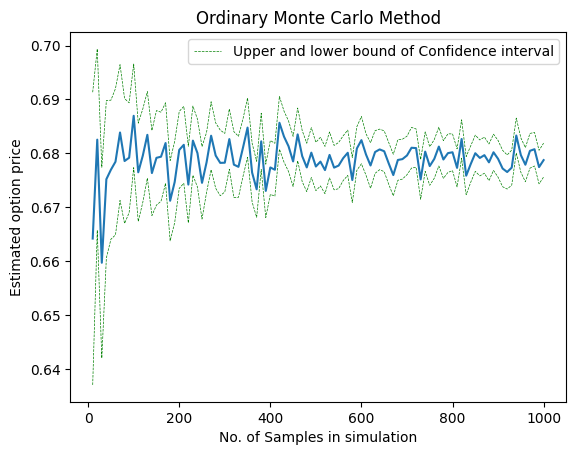

In [16]:
print("Price estimated at largest sample size with ordinary MC:", str(ordinaryMC_price_esitmates[-1]))
print("CI length at largest sample size with ordinary MC:", str(ordinaryMC_CIs[-1,1] - ordinaryMC_CIs[-1,0]))

#Ploting ordinary Monte Carlo method
x_axis1 = range(10, max_sample + 1, 10)
plt.plot(x_axis1, ordinaryMC_price_esitmates)
plt.plot(x_axis1, ordinaryMC_CIs[1:, 0], 'g--', lw=0.5, label='Upper and lower bound of Confidence interval')
plt.plot(x_axis1, ordinaryMC_CIs[1:, 1], 'g--', lw=0.5)
plt.xlabel("No. of Samples in simulation")
plt.ylabel("Estimated option price")
plt.title("Ordinary Monte Carlo Method")
plt.legend()
plt.show()


In [17]:
import comparaison

In [18]:
CI = ordinaryMC_CIs
tol = 0.005
mc_threshold = comparaison.threshold_finder(CI, tol)
#sample_convergent = mc_threshold * 10
sample_convergent = 1500



In [19]:
CPU_sample = comparaison.CPU(sample_convergent,k, S_0, T, r, sigma, K, alpha, b)
CPU_sample


0.13798279999900842

In [20]:
mean_pv_payoffs_cvg = 0.678999222272018
max_sample = 100

In [22]:

mse_values = comparaison.mse_comparaison(max_sample, k, S_0, T, r, sigma, K, alpha, b, mean_pv_payoffs_cvg)[0]

10
20
30
40
50
60
70
80
90
100


In [24]:
mse_values
# Je ne comprends pas pourquoi je trouve ce résultat, je ne suis pas censé obtenir ça

array([2.40998789e-04, 1.44109938e-04, 8.61828092e-05, 6.98804112e-05,
       4.78530355e-05, 4.55821394e-05, 4.25432547e-05, 3.13696483e-05,
       2.79471374e-05, 2.49978628e-05])

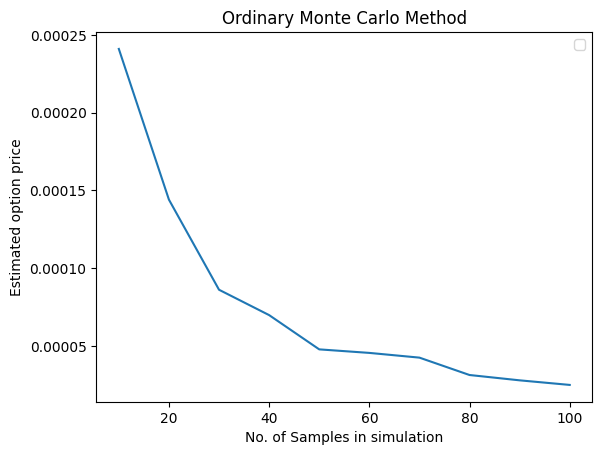

In [25]:
x_axis1 = range(10, max_sample + 1, 10)
plt.plot(x_axis1, mse_values)
plt.xlabel("No. of Samples in simulation")
plt.ylabel("Estimated option price")
plt.title("Ordinary Monte Carlo Method")
plt.legend()
plt.show()

# Quasi Monte Carlo

# tests Sobol generator

In [26]:
nb_samples = 100

In [27]:
sobol = CIR.sobol_generator(nb_samples, k)
print(sobol, len(sobol), len(sobol[1,]))

[[0.5     0.75    0.25    ... 0.84375 0.34375 0.46875]
 [0.5     0.25    0.75    ... 0.21875 0.71875 0.09375]
 [0.5     0.75    0.25    ... 0.09375 0.59375 0.46875]
 ...
 [0.75    0.25    0.875   ... 0.53125 0.15625 0.65625]
 [0.75    0.25    0.375   ... 0.09375 0.21875 0.71875]
 [0.75    0.25    0.125   ... 0.78125 0.65625 0.15625]] 117 20


# tests CIR_QMC

In [28]:
M = CIR.multiCIR_QMC(alpha, b, sigma, T, k, S_0, nb_samples)

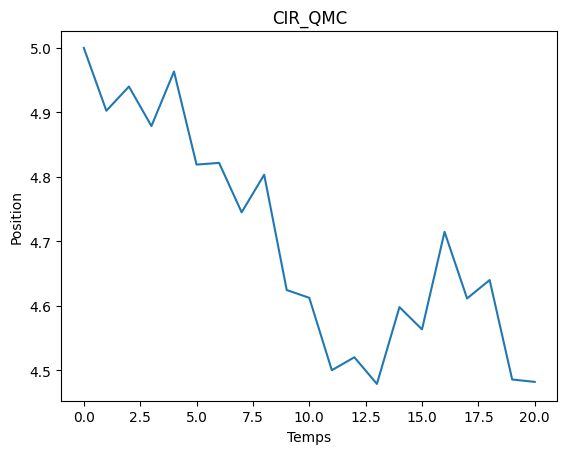

In [29]:
plt.plot(M[1])
plt.xlabel('Temps')
plt.ylabel('Position')
plt.title('CIR_QMC')
plt.show()

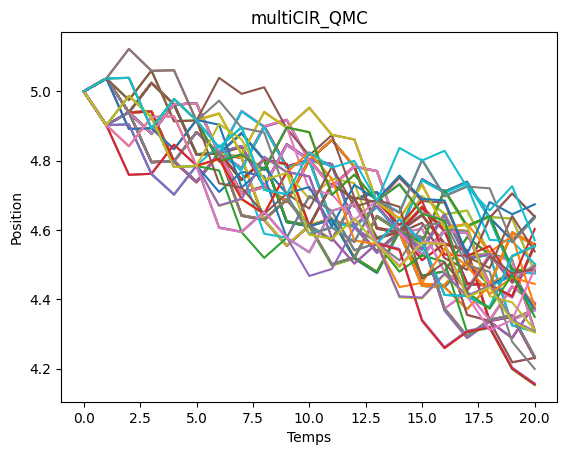

In [30]:
for i in range(nb_samples):
    plt.plot(M[i])
plt.xlabel('Temps')
plt.ylabel('Position')
plt.title('multiCIR_QMC')
plt.show()

# Quasi Monte Carlos

In [31]:
import ordinaryMC
import QMC

In [32]:
ordinaryMC.pv_calc(M[3],r, T)

array([4.75614712, 4.66345079, 4.69914028, 4.56226408, 4.56486702,
       4.50807057, 4.58792692, 4.60631592, 4.49585464, 4.61115062,
       4.56896722, 4.55650063, 4.38662669, 4.44190474, 4.37079301,
       4.3235163 , 4.41775917, 4.2991677 , 4.31043676, 4.23279869,
       4.27786066])

In [33]:
OMC_QMC = QMC.QMC_mc_sim(nb_samples, k, S_0, T, r, sigma, K, alpha, b)
np.mean(OMC_QMC)

0.6729958803021122

In [34]:
QMC.sim_iterator_QMC(1000, k, S_0, T, r, sigma, K, alpha, b)

(array([0.67030405, 0.66890891, 0.67289144, 0.67368627, 0.67307766,
        0.67222133, 0.67397267, 0.67343756, 0.67302825, 0.67299588,
        0.67232377, 0.67187278, 0.67152841, 0.67126818, 0.67215052,
        0.67281187, 0.67259377, 0.67073935, 0.67169282, 0.67153946,
        0.67227589, 0.67190686, 0.67178969, 0.67184999, 0.67205816,
        0.67217644, 0.67262645, 0.67164796, 0.67172295, 0.67181705,
        0.67182892, 0.67229061, 0.6728063 , 0.67348223, 0.67445719,
        0.67504915, 0.67634998, 0.67519357, 0.67572613, 0.6758411 ,
        0.67625629, 0.67650668, 0.67647068, 0.6763089 , 0.67627988,
        0.67621747, 0.67684416, 0.67628533, 0.67630456, 0.67596895,
        0.67577944, 0.67526663, 0.6755823 , 0.67539858, 0.67540742,
        0.67461142, 0.67503888, 0.67527696, 0.67473238, 0.67455601,
        0.67449193, 0.67466979, 0.67458252, 0.67376248, 0.67401107,
        0.67360358, 0.67293898, 0.67269142, 0.67246486, 0.67160056,
        0.67168216, 0.67152864, 0.67133645, 0.67

# Comparaison QMC

In [35]:
max_sample = 1000


sobol_price_esitmates, sobol_CIs = QMC.sim_iterator_QMC(max_sample, k, S_0, T, r, sigma, K, alpha, b)

In [36]:
print("Price estimated at largest sample size with Sobol sequence:", str(sobol_price_esitmates[-1]))
print("CI length at largest sample size with Sobol sequence:", str(sobol_CIs[-1,1] - sobol_CIs[-1,0]))


Price estimated at largest sample size with Sobol sequence: 0.672063980448986
CI length at largest sample size with Sobol sequence: 0.009965255969321296


ValueError: x and y must have same first dimension, but have shapes (10,) and (100,)

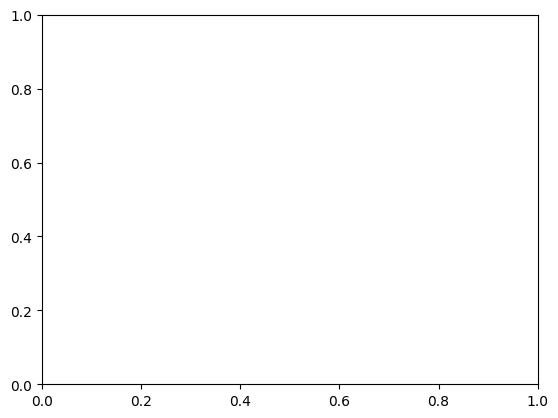

In [37]:
#Ploting quasi-Monte Carlo method using Sobol sequence

plt.plot(x_axis1, sobol_price_esitmates)
plt.plot(x_axis1, sobol_CIs[1:, 0], 'g--', lw=0.5, label='Upper and lower bound of Confidence interval')
plt.plot(x_axis1, sobol_CIs[1:, 1], 'g--', lw=0.5)
plt.xlabel("No. of Samples in simulation")
plt.ylabel("Estimated option price")
plt.title("QMC (Sobol Sequence) Method")
plt.legend()
plt.show()

In [38]:
tol = 0.01
sobol_threshold = comparaison.threshold_finder(sobol_CIs, tol)

99


In [39]:
sample_convergent_QMC = sobol_threshold * 10

In [40]:
CPU_sample_QMC = comparaison.CPU(sample_convergent_QMC,k, S_0, T, r, sigma, K, alpha, b)
CPU_sample_QMC

0.0986398500026553

In [41]:
mse_values_QMC = comparaison.mse_comparaison_QMC(max_sample, k, S_0, T, r, sigma, K, alpha, b, mean_pv_payoffs_cvg)[0]


AttributeError: module 'ordinaryMC' has no attribute 'QMC_mc_sim_random'

In [ ]:
x_axis1 = range(10, max_sample + 1, 10)
plt.plot(x_axis1, mse_values)
plt.plot(x_axis1, mse_values_QMC, 'g--', lw=0.5, label='Upper and lower bound of Confidence interval')
plt.xlabel("No. of Samples in simulation")
plt.ylabel("Estimated option price")
plt.title("Ordinary Monte Carlo Method")
plt.legend()
plt.show()

# tests Multi Level CIR

In [ ]:
pip install chaospy

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import CIR

In [ ]:
L = 5

In [ ]:
S = CIR.level_CIR(alpha, b, sigma, L, T, S_0)

In [ ]:
S

(array([0.     , 0.03125, 0.0625 , 0.09375, 0.125  , 0.15625, 0.1875 ,
        0.21875, 0.25   , 0.28125, 0.3125 , 0.34375, 0.375  , 0.40625,
        0.4375 , 0.46875, 0.5    , 0.53125, 0.5625 , 0.59375, 0.625  ,
        0.65625, 0.6875 , 0.71875, 0.75   , 0.78125, 0.8125 , 0.84375,
        0.875  , 0.90625, 0.9375 , 0.96875, 1.     ]),
 array([5.        , 4.98554223, 4.98008483, 4.98313041, 4.95860946,
        4.92040272, 4.89377591, 4.86386636, 4.83828826, 4.81721954,
        4.78850722, 4.75295305, 4.7390408 , 4.72588816, 4.70760075,
        4.68405328, 4.66575521, 4.63697818, 4.60866094, 4.61203315,
        4.59729617, 4.59455355, 4.57607571, 4.56786809, 4.53089251,
        4.5330351 , 4.52728162, 4.49842118, 4.48234802, 4.48367529,
        4.45862654, 4.45584038, 4.47713446]))

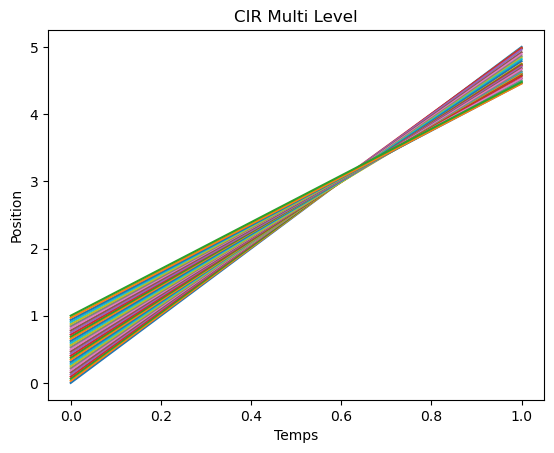

In [ ]:
plt.plot(S)
plt.xlabel('Temps')
plt.ylabel('Position')
plt.title('CIR Multi Level')
plt.show()

In [ ]:
nb_samples = 100 

In [ ]:
M = CIR.multiCIR_ML_principle(alpha, b, sigma, L, T, S_0)

IndexError: tuple index out of range

In [ ]:
multiCIR=[]
M = CIR.CIR_new(alpha, b, sigma, 1/100, T, S_0)
multiCIR.append(M)


In [ ]:
multiCIR

[(array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
         0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
         0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
         0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
         0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
         0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
         0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
         0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
         0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
         0.99, 1.  ]),
  array([5.        , 5.00135854, 4.98907303, 4.98949351, 4.98629569,
         4.98191239, 4.97766297, 4.96819992, 4.9666978 , 4.96183823,
         4.95551228, 4.9509645 , 4.94345028, 4.93719524, 4.93131603,
         4.9326946 , 4.92484037, 4.9224894 , 4.91972773, 4.91773276,
         4.91720628, 4.910

In [ ]:
for j in range(10): 
    A = ([multiCIR[j][0][i] for i in range(0,len(multiCIR[j][0]),2)],[multiCIR[j][1][i] for i in range(0,len(multiCIR[j][0]),2)])
    multiCIR.append(A)

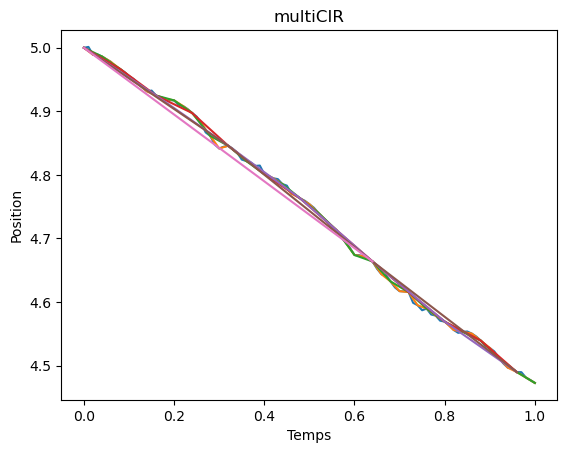

In [ ]:
for i in range(10):
    plt.plot(multiCIR[i][0],multiCIR[i][1])
plt.xlabel('Temps')
plt.ylabel('Position')
plt.title('multiCIR')
plt.show()

In [ ]:
zap = CIR.CIR(alpha, b, sigma, T, k, S_0)
zap2 = CIR.CIR_ML(alpha, b, sigma, T, k, S_0,5)

In [ ]:
zap

In [ ]:
zap2

array([1000.        ,  990.46117392,  981.39982838,  971.68914217,
        962.85992471,  953.91998516,  944.74041551,  935.56966166,
        926.50960883,  917.71959879,  908.92410262,  900.20829462,
        891.47485445,  882.91834458,  875.56105974,  867.225721  ,
        859.17785251,  851.25730492,  843.06987932,  835.17311589,
        827.94049722])

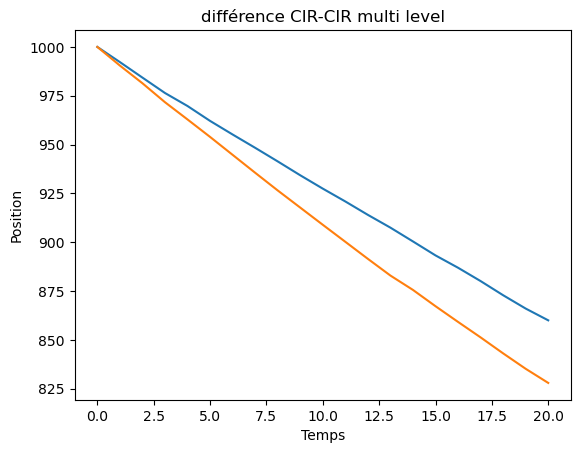

In [ ]:
plt.plot(zap)
plt.plot(zap2)
plt.xlabel('Temps')
plt.ylabel('Position')
plt.title('différence CIR-CIR multi level')
plt.show()

# Multi Level Monte Carlo

In [ ]:
import MLMC

In [ ]:
import CIR

In [ ]:
L = 10

In [ ]:
MLMC.level_mc_sim(nb_samples, S_0, T, r, sigma, K, alpha, b, L)

0.6795832819110003

In [ ]:
multiCIR_test = CIR.multiCIR_ML(alpha, b, sigma, L, T, S_0, nb_samples)

In [ ]:
MLMC.mc_telescopic_sum(alpha, b, sigma, L, T, S_0, nb_samples, r, K)

coucou


0.6469375713746368

In [ ]:
MLMC_test = MLMC.sim_MLMC(k, S_0, T, r, sigma, K, alpha, b)

Le ordinary tu fais n fois avec la même dicrétisation alors que le multi level tu fais n fois mais avec des discrétisations de plus en plus fines. Et en plus c'est "gratuit" car on utilise le même mouvement brownien.